In [247]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler

import numpy as np
import matplotlib.pyplot as plt

In [248]:
input_size = 784
hidden_size = 2048
num_classes = 10
num_epochs = 20
batch_size = 100
learning_rate = 0.1

In [249]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='StandardData', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='StandardData', 
                                          train=False, 
                                          transform=transforms.ToTensor())

reduced_train_index=list(range(10000))
reduced_test_index=list(range(2000))

subset_train_dataset=torch.utils.data.Subset(train_dataset, reduced_train_index)
subset_test_dataset=torch.utils.data.Subset(test_dataset, reduced_test_index)

# Data loader
train_loader = DataLoader(dataset=subset_train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=subset_test_dataset, batch_size=batch_size, shuffle=False) 

In [250]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        return x

In [251]:
# Train the model

model_RealData = NeuralNet(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_RealData.parameters(), lr=learning_rate) 

def train_epoch():
    gradients=[]
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model_RealData(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        batch_gradients=[]
        for ten in model_RealData.fc1.weight.grad:
            batch_gradients+=ten.tolist()
        batch_gradients+=model_RealData.fc1.bias.grad.tolist()
        for ten in model_RealData.fc2.weight.grad:
            batch_gradients+=ten.tolist()
        batch_gradients+=model_RealData.fc2.bias.grad.tolist()
        optimizer.step()
        gradients.append(np.array(batch_gradients))
    expected_gradient=np.zeros(len(gradients[0]))
    expected_dot=0
    n=len(gradients)
    for grad in gradients:
        expected_gradient+=grad/n
        expected_dot+=np.dot(grad,grad)
    batchwise_coherence=np.dot(expected_gradient,expected_gradient)/expected_dot
    k=len(train_loader)
    perexample_coherence=batchwise_coherence/(k-(k-1)*batchwise_coherence)
    return loss.item(), perexample_coherence*10000

def accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model_RealData(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return correct/total

def loss(loader):
    with torch.no_grad():
        loss = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model_RealData(images)
            loss += criterion(outputs, labels).item()*labels.size(0)
            total += labels.size(0)
        return loss/total

train_loss=[]
train_accuracy=[]
test_loss=[]
test_accuracy=[]
epoch_list=[]
alpha_list=[]

for epoch in range(num_epochs):
    trainloss, alpha = train_epoch()
    train_loss.append(trainloss)
    alpha_list.append(alpha)
    train_accuracy.append(accuracy(train_loader))
    test_loss.append(loss(test_loader))
    test_accuracy.append(accuracy(test_loader))
    print('Epoch: {} TrainLoss: {:.3f} TestLoss: {:.3f} TrainAccuracy: {:.3f} TestAccuracy: {:.3f} Coherence: {:.3f}'.format(epoch+1,train_loss[-1],test_loss[-1],train_accuracy[-1],test_accuracy[-1],alpha_list[-1]))

Epoch: 1 TrainLoss: 0.396 TestLoss: 0.608 TrainAccuracy: 0.878 TestAccuracy: 0.842 Coherence: 0.192
Epoch: 2 TrainLoss: 0.351 TestLoss: 0.474 TrainAccuracy: 0.903 TestAccuracy: 0.865 Coherence: 0.023
Epoch: 3 TrainLoss: 0.209 TestLoss: 0.421 TrainAccuracy: 0.917 TestAccuracy: 0.878 Coherence: 0.010
Epoch: 4 TrainLoss: 0.300 TestLoss: 0.398 TrainAccuracy: 0.924 TestAccuracy: 0.884 Coherence: 0.007
Epoch: 5 TrainLoss: 0.271 TestLoss: 0.371 TrainAccuracy: 0.930 TestAccuracy: 0.890 Coherence: 0.005
Epoch: 6 TrainLoss: 0.262 TestLoss: 0.358 TrainAccuracy: 0.935 TestAccuracy: 0.893 Coherence: 0.005
Epoch: 7 TrainLoss: 0.281 TestLoss: 0.340 TrainAccuracy: 0.940 TestAccuracy: 0.901 Coherence: 0.004
Epoch: 8 TrainLoss: 0.281 TestLoss: 0.329 TrainAccuracy: 0.943 TestAccuracy: 0.902 Coherence: 0.004
Epoch: 9 TrainLoss: 0.278 TestLoss: 0.321 TrainAccuracy: 0.946 TestAccuracy: 0.901 Coherence: 0.004
Epoch: 10 TrainLoss: 0.271 TestLoss: 0.311 TrainAccuracy: 0.951 TestAccuracy: 0.908 Coherence: 0.004

Text(0.5, 1.0, 'Coherence')

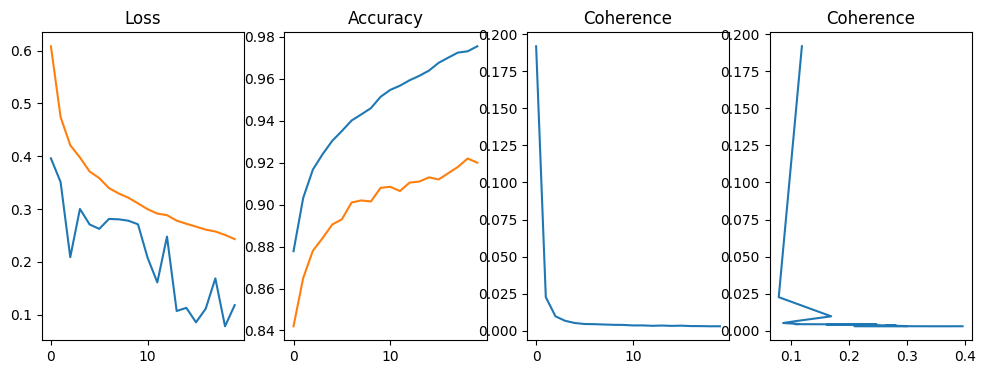

In [252]:
fig, axs = plt.subplots(1,4)

fig.set_size_inches(12,4)

axs[0].plot(np.arange(num_epochs), train_loss,label='Train')
axs[0].plot(np.arange(num_epochs), test_loss,label='Test')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(np.arange(num_epochs), train_accuracy,label='Train')
axs[1].plot(np.arange(num_epochs), test_accuracy,label='Test')
axs[1].set_title('Accuracy')
axs[1].legend()
axs[2].plot(np.arange(num_epochs), alpha_list,label='Coherence')
axs[2].set_title('Coherence Against Epochs')
axs[2].legend()
axs[3].plot(np.flip(train_loss), alpha_list,label='Coherence')
axs[3].set_title('Coherence Against Loss')
axs[3].legend()

In [253]:
input_size = 784
hidden_size = 2048
num_classes = 10
num_epochs = 20
batch_size = 100
learning_rate = 0.1

In [254]:
# MNIST dataset 
random_train_dataset = torchvision.datasets.MNIST(root='ShuffledData', 
                                           train=True, 
                                           transform=transforms.ToTensor(), 
                                           target_transform=lambda y: torch.randint(0, 4, (1,)).item() if y<=4 else y, 
                                           download=True)

random_test_dataset = torchvision.datasets.MNIST(root='ShuffledData', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          target_transform=lambda y: torch.randint(0, 4, (1,)).item() if y<=4 else y)

reduced_train_index=list(range(10000))
reduced_test_index=list(range(2000))

subset_random_train_dataset=torch.utils.data.Subset(random_train_dataset, reduced_train_index)
subset_random_test_dataset=torch.utils.data.Subset(random_test_dataset, reduced_test_index)

# Data loader
random_train_loader = DataLoader(dataset=subset_random_train_dataset, batch_size=batch_size, shuffle=True)

random_test_loader = DataLoader(dataset=subset_random_test_dataset, batch_size=batch_size, shuffle=False) 

In [255]:
model_RandomData = NeuralNet(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_RandomData.parameters(), lr=learning_rate) 

def r_train_epoch():
    gradients=[]
    for images, labels in random_train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model_RandomData(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        batch_gradients=[]
        for ten in model_RandomData.fc1.weight.grad:
            batch_gradients+=ten.tolist()
        batch_gradients+=model_RandomData.fc1.bias.grad.tolist()
        for ten in model_RandomData.fc2.weight.grad:
            batch_gradients+=ten.tolist()
        batch_gradients+=model_RandomData.fc2.bias.grad.tolist()
        optimizer.step()
        gradients.append(np.array(batch_gradients))
    expected_gradient=np.zeros(len(gradients[0]))
    expected_dot=0
    n=len(gradients)
    for grad in gradients:
        expected_gradient+=grad/n
        expected_dot+=np.dot(grad,grad)
    batchwise_coherence=np.dot(expected_gradient,expected_gradient)/expected_dot
    k=len(train_loader)
    perexample_coherence=batchwise_coherence/(k-(k-1)*batchwise_coherence)
    return loss.item(), perexample_coherence*10000

def r_accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            labels = labels
            outputs = model_RandomData(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return correct/total

def r_loss(loader):
    with torch.no_grad():
        loss = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            labels = labels
            outputs = model_RandomData(images)
            loss += criterion(outputs, labels).item()*labels.size(0)
            total += labels.size(0)
        return loss/total

random_train_loss=[]
random_train_accuracy=[]
random_test_loss=[]
random_test_accuracy=[]
random_alpha_list=[]

for epoch in range(num_epochs):
    random_trainloss, random_alpha = r_train_epoch()
    random_train_loss.append(random_trainloss)
    random_alpha_list.append(random_alpha)
    random_train_accuracy.append(r_accuracy(random_train_loader))
    random_test_loss.append(r_loss(random_test_loader))
    random_test_accuracy.append(r_accuracy(random_test_loader))
    print('Epoch: {} TrainLoss: {:.3f} TestLoss: {:.3f} TrainAccuracy: {:.3f} TestAccuracy: {:.3f} Coherence: {:.3f}'.format(epoch+1,random_train_loss[-1],random_test_loss[-1],random_train_accuracy[-1],random_test_accuracy[-1],random_alpha_list[-1]))

Epoch: 1 TrainLoss: 1.357 TestLoss: 1.357 TrainAccuracy: 0.532 TestAccuracy: 0.465 Coherence: 0.089
Epoch: 2 TrainLoss: 1.159 TestLoss: 1.236 TrainAccuracy: 0.548 TestAccuracy: 0.495 Coherence: 0.014
Epoch: 3 TrainLoss: 1.151 TestLoss: 1.176 TrainAccuracy: 0.556 TestAccuracy: 0.517 Coherence: 0.007
Epoch: 4 TrainLoss: 1.095 TestLoss: 1.167 TrainAccuracy: 0.566 TestAccuracy: 0.506 Coherence: 0.005
Epoch: 5 TrainLoss: 1.118 TestLoss: 1.120 TrainAccuracy: 0.566 TestAccuracy: 0.524 Coherence: 0.005
Epoch: 6 TrainLoss: 1.007 TestLoss: 1.090 TrainAccuracy: 0.576 TestAccuracy: 0.530 Coherence: 0.004
Epoch: 7 TrainLoss: 0.980 TestLoss: 1.077 TrainAccuracy: 0.583 TestAccuracy: 0.543 Coherence: 0.005
Epoch: 8 TrainLoss: 0.873 TestLoss: 1.054 TrainAccuracy: 0.587 TestAccuracy: 0.526 Coherence: 0.004
Epoch: 9 TrainLoss: 0.829 TestLoss: 1.040 TrainAccuracy: 0.587 TestAccuracy: 0.544 Coherence: 0.004
Epoch: 10 TrainLoss: 0.846 TestLoss: 1.034 TrainAccuracy: 0.587 TestAccuracy: 0.538 Coherence: 0.003

Text(0.5, 1.0, 'Coherence Against Loss')

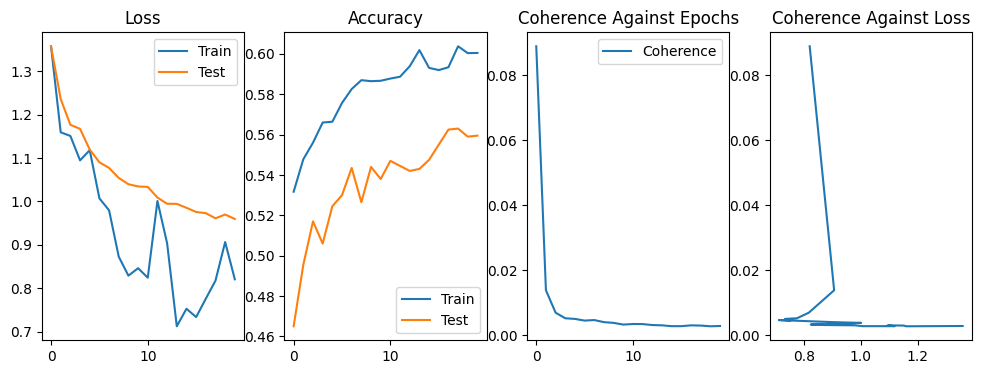

In [261]:
fig, axs = plt.subplots(1,4)

fig.set_size_inches(12,4)

axs[0].plot(np.arange(num_epochs), random_train_loss,label='Train')
axs[0].plot(np.arange(num_epochs), random_test_loss,label='Test')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(np.arange(num_epochs), random_train_accuracy,label='Train')
axs[1].plot(np.arange(num_epochs), random_test_accuracy,label='Test')
axs[1].set_title('Accuracy')
axs[1].legend()
axs[2].plot(np.arange(num_epochs), random_alpha_list,label='Coherence')
axs[2].set_title('Coherence Against Epochs')
axs[2].legend()
axs[3].plot(np.flip(random_train_loss), random_alpha_list,label='Coherence')
axs[3].set_title('Coherence Against Loss')

Here approximately $50$% of the data is clean and the rest is randomized. Hence, we see that accuracy is much lower than the clean case.